In [337]:
%cd /mnt/home/tnguyen/projects/florah/florah-tree
%load_ext autoreload
%autoreload 2

import os
import h5py
import pickle
import time
from pathlib import Path

import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import torch_geometric
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from ml_collections import config_dict

from florah_analysis import tree_utils, utils

from models import training_utils, models, models_utils, flows_utils
from models import generator

/mnt/home/tnguyen/projects/florah/florah-tree
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def prepare_dataloader(
    data, train_frac=0.8, batch_size=1024, num_workers=1,
    norm_dict=None):

    num_total = len(data)
    num_train = int(num_total * train_frac)

    np.random.shuffle(data)

    # calculate the normaliziation statistics
    x = torch.cat([d.x for d in data[:num_train]])
    if norm_dict is None:
        x_loc = x.mean(dim=0)
        x_scale = x.std(dim=0)
        norm_dict = {
            "x_loc": list(x_loc.numpy()),
            "x_scale": list(x_scale.numpy()),
        }
    else:
        x_loc = torch.tensor(norm_dict["x_loc"], dtype=torch.float)
        x_scale = torch.tensor(norm_dict["x_scale"], dtype=torch.float)
    for d in data:
        d.x = (d.x - x_loc) / x_scale

    train_loader = DataLoader(
        data[:num_train], batch_size=batch_size, shuffle=True, 
        num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(
        data[num_train:], batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, norm_dict

In [4]:
# Fake config 
config = config_dict.ConfigDict()
config.workdir = './logging/'
config.name = 'GUREFT05-Nanc1.transfGenerator'

# Read in the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = "/mnt/home/tnguyen/projects/florah/florah-tree/"\
    "logging/GUREFT05-Nanc1.transfGenerator/version_0/checkpoints/epoch=137-step=43056.ckpt"
model = generator.TreeGenerator.load_from_checkpoint(
    checkpoint_path, map_location=device)
norm_dict = model.norm_dict

# Read in the dataset
dset_path = '/mnt/ceph/users/tnguyen/florah/datasets/experiments/GUREFT05-Nanc1.debug.pkl'
with open(dset_path, 'rb') as f:
    data = pickle.load(f)

# convert networkx to pytorch geometric
data_pyg = [from_networkx(d) for d in data]
train_loader, val_loader, norm_dict = prepare_dataloader(
    data_pyg, batch_size=1, norm_dict=norm_dict)
batch = next(iter(train_loader))

/mnt/home/tnguyen/miniconda3/envs/geometric/lib/python3.11/site-packages/torch_geometric/utils/convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data[key] = torch.tensor(value)


In [316]:
def generate_tree(
    model, root_halo_feat, t_out, n_max_iter=1000, norm_dict=None):
    """Generate a tree from a root halo feature vector. 
    Assume root_halo_feat and t_out are already normalized.
    """
    # create list of output times
    if not isinstance(t_out, torch.Tensor):
        t_out = torch.tensor(t_out, dtype=torch.float32)
    t_out = t_out.to(device)

    if not isinstance(root_halo_feat, torch.Tensor):
        root_halo_feat = torch.tensor(root_halo_feat, dtype=torch.float32)
    root_halo_feat = root_halo_feat.to(device)
    root_halo_feat = torch.cat([root_halo_feat, t_out[0].unsqueeze(0)])

    # initialize the tree
    halo_t_index = [0]
    halo_index = [0]
    halo_remain_index = [0]  # index of the remining halos to be processed
    next_halo_index = 1
    halo_feats = torch.stack([root_halo_feat], dim=0)
    edge_index= [[], []]  # keep edge index as a list to make appending easier
    next_halo_index = 1

    model.eval()
    with torch.no_grad():
        while (len(halo_remain_index) > 0) & (n_max_iter > 0):
            halo_curr_index = halo_remain_index.pop(0)
            halo_curr_t_index = halo_t_index.pop(0)
            if halo_curr_t_index == len(t_out) - 1:
                # reach the last snapshot
                continue
            t_next = t_out[halo_curr_t_index + 1]
            t_next = t_next.unsqueeze(0).unsqueeze(0)  # add batch and feature dim

            # input features
            path = training_utils.find_path_from_root(
                torch.tensor(edge_index, dtype=torch.long),
                halo_curr_index)
            x_feat = model.featurizer(halo_feats[path].unsqueeze(0)) # add batch dim
            t_proj = model.time_proj_layer(t_next)

            # randomly sample the number of progenitors
            x_classifier = torch.cat((x_feat, t_proj), dim=1)
            yhat = model.classifier(x_classifier).softmax(dim=1)
            num_progs = torch.multinomial(yhat, 1) + 1
            num_progs = num_progs.item()

            # list of progenitors, including the zeros starting token
            x_progs = torch.zeros((1, num_progs + 1, 2), device=device)
            t_proj_progs = t_proj.unsqueeze(1).repeat(1, num_progs + 1, 1)

            for i_prog in range(num_progs):
                n_prog_curr = i_prog + 1  # number of progenitors at current step

                lengths = torch.tensor([n_prog_curr], dtype=torch.long)
                f_proj = model.feat_proj_layer(x_progs)

                # run the RNN to extract the context
                x_rnn = torch.cat([f_proj, t_proj_progs], dim=-1)
                x_rnn = model.rnn(x_rnn, lengths=lengths)

                # # sample from the flow
                flow_context = torch.cat(
                    [x_rnn, x_feat.unsqueeze(1).repeat(1, n_prog_curr, 1)], dim=-1)
                flow_context = flow_context[:, -1]  # only take the last time step
                x_prog_curr = model.flows.sample(1, context=flow_context)

                # append to the list of progenitors
                x_progs[:, i_prog + 1] = x_prog_curr
            x_progs = x_progs[:, 1:]  # remove the zeros starting token]

            # add the progenitors to the list of halos
            x_progs = torch.cat([x_progs, t_next.repeat(1, num_progs, 1)], dim=-1)
            x_progs = x_progs.squeeze(0)  # remove the batch dim
            halo_feats = torch.cat([halo_feats, x_progs], dim=0)

            # create halo index for the progneitors
            prog_index = [next_halo_index + i for i in range(num_progs)]
            halo_index = halo_index + prog_index
            halo_remain_index = halo_remain_index + prog_index
            halo_t_index = halo_t_index + [halo_curr_t_index + 1] * num_progs

            # create edge index for the progenitors
            edge_index[0] = edge_index[0] + [halo_curr_index] * num_progs
            edge_index[1] = edge_index[1] + prog_index
            next_halo_index += num_progs

            n_max_iter -= 1
            if n_max_iter == 0:
                print('Max number of iterations reached')

    data = Data(x=halo_feats, edge_index=torch.tensor(edge_index, dtype=torch.long))

    if norm_dict is not None:
        x_loc_norm = torch.tensor(
            norm_dict['x_loc'], dtype=torch.float32, device=device)
        x_scale_norm = torch.tensor(
            norm_dict['x_scale'], dtype=torch.float32, device=device)
        data.x = data.x * x_scale_norm + x_loc_norm

    return data

In [360]:
snaps, aexp_snaps, z_snaps = utils.read_snapshot_times('GUREFT05')
num_snap_max = np.where(z_snaps > 10)[0][0]
step = 2
aexp_out = aexp_snaps[:num_snap_max:step]
x_loc_norm = torch.tensor(norm_dict['x_loc'], dtype=torch.float32)
x_scale_norm = torch.tensor(norm_dict['x_scale'], dtype=torch.float32)

# create list of output times
t_out = torch.tensor(aexp_out, dtype=torch.float32)
t_out = (t_out - x_loc_norm[-1]) / x_scale_norm[-1]

/mnt/home/tnguyen/miniconda3/envs/geometric/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:304: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


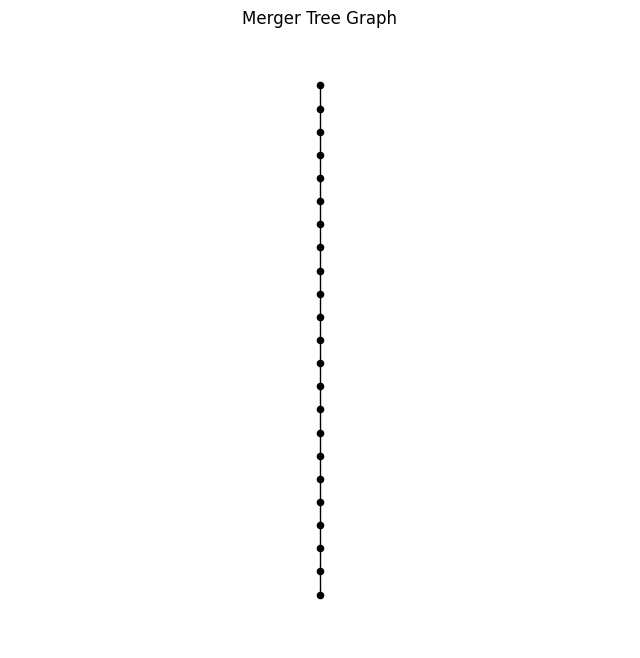

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Merger Tree Graph'}>)

In [368]:
# get an initial mass and concentration
root_halo_feat = batch.x[8][:-1]
data = generate_tree(model, root_halo_feat, t_out, norm_dict=norm_dict)
data = data.cpu()

# convert to a networkx graph manually since the to_networkx method is not working
# for some reason
G = nx.Graph()
G.add_nodes_from(range(len(data.x)))
G.add_edges_from(data.edge_index.T.numpy())
for i in range(len(data.x)):
    G.nodes[i]['x'] = data.x[i].numpy()

tree_utils.plot_graph(G)